✅ Data shape: (400, 10, 64, 64, 3) (400,)
🚀 Starting Tier 2 Training...
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.5088 - loss: 0.6894 - val_accuracy: 0.6833 - val_loss: 0.6779
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.5394 - loss: 0.6815 - val_accuracy: 0.5167 - val_loss: 0.6751
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.6335 - loss: 0.6733 - val_accuracy: 0.7167 - val_loss: 0.6662
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7040 - loss: 0.6576 - val_accuracy: 0.7500 - val_loss: 0.6528
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7515 - loss: 0.6538 - val_accuracy: 0.7833 - val_loss: 0.6441
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7370 - loss: 0.6407 - val_accuracy: 0.7500 - val_loss: 0.6311
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7827 - loss: 0.6331 - val_accuracy: 0.8500 - val_loss: 0.6223
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 

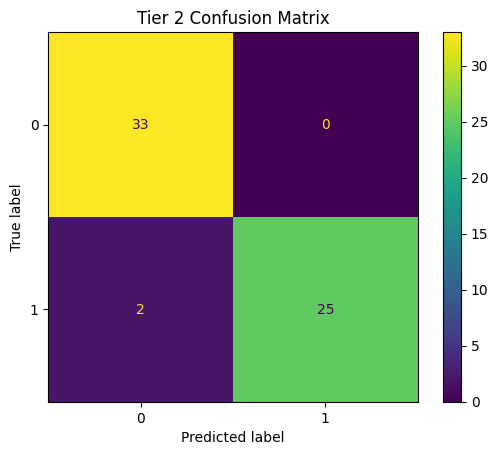

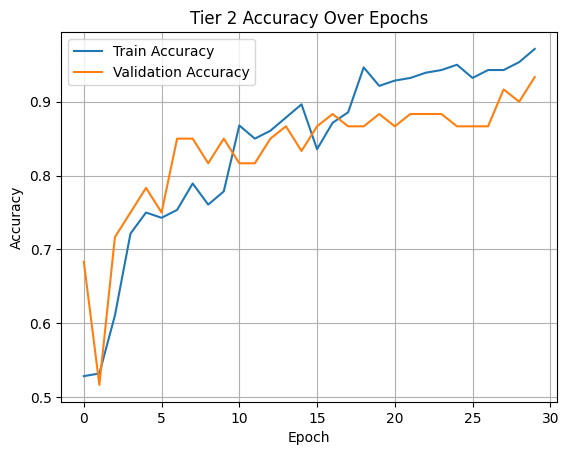

In [3]:
# ✅ FIXED TIER 2 MODEL WITH ATTENTION
# The attention mechanism must be defined in __init__ to avoid tf.function issues

import os
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     LSTM, TimeDistributed, Bidirectional, Layer, Multiply, Permute, RepeatVector, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# -------- CONFIG --------
MODALITIES = 3
DAYS = 10
IMG_SIZE = (64, 64)
DATA_DIR = "/kaggle/input/hab-200/dataset_200"

# -------- LOAD FUNCTION -------- 
def load_satellite_image_sequence():
    X_raw, y = [], []
    for label in ["0", "1"]:
        label_path = os.path.join(DATA_DIR, label)
        for sample_id in os.listdir(label_path):
            sample_path = os.path.join(label_path, sample_id)
            modalities = sorted(os.listdir(sample_path))[:MODALITIES]
            cube = []

            for mod in modalities:
                mod_path = os.path.join(sample_path, mod)
                day_images = []
                for d in range(1, DAYS + 1):
                    img_path = os.path.join(mod_path, f"{str(d).zfill(2)}.png")
                    if os.path.exists(img_path):
                        img = Image.open(img_path).resize(IMG_SIZE).convert("L")
                        img_np = np.array(img)
                        day_images.append(img_np)

                if len(day_images) == DAYS:
                    cube.append(day_images)

            if len(cube) == MODALITIES:
                cube_np = np.transpose(np.array(cube), (1, 2, 3, 0))  # (DAYS, H, W, MODALITIES)
                X_raw.append(cube_np)
                y.append(int(label))

    return np.array(X_raw), np.array(y)

# -------- ATTENTION LAYER --------
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.dense1 = Dense(1, activation='tanh')
        self.flatten = Flatten()
        self.softmax = Dense(DAYS, activation='softmax')
        self.repeat = RepeatVector(256)
        self.permute = Permute([2, 1])

    def call(self, inputs):
        attention_scores = self.dense1(inputs)
        attention_weights = self.flatten(attention_scores)
        attention_weights = self.softmax(attention_weights)
        attention_weights = self.repeat(attention_weights)
        attention_weights = self.permute(attention_weights)
        return Multiply()([inputs, attention_weights])

# -------- ADVANCED HABNet MODEL --------
def train_tier2_habnet():
    X_raw, y = load_satellite_image_sequence()
    print("✅ Data shape:", X_raw.shape, y.shape)

    y_cat = to_categorical(y, num_classes=2)

    X_train, X_temp, y_train, y_temp = train_test_split(X_raw, y_cat, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    input_shape = (DAYS, IMG_SIZE[0], IMG_SIZE[1], MODALITIES)
    inputs = Input(shape=input_shape)

    # TimeDistributed CNN block
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = AttentionLayer()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print("🚀 Starting Tier 2 Training...")
    start = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=1
    )
    end = time.time()
    print("\n✅ Time taken:", round(end - start, 2), "seconds")

    print("\n📊 Evaluation on Test Set:")
    loss, acc = model.evaluate(X_test, y_test)
    print("Test Accuracy:", acc)

    y_pred = model.predict(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Tier 2 Confusion Matrix")
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Tier 2 Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------- EXECUTE --------
train_tier2_habnet()
